# Problem 2

*From a large population-based case–control study on Oral cancer conducted in the US (Day et al., 1993), the data related to the African American population (194 cases, here ccstatus = 1, and 203 controls, here ccstatus = 0) has been selected. The aim of the study is to evaluate the risk of Oral cancer based on the variables drinks (number of 1oz ethanol-equivalent drinks consumed per week), sex, age and cigs (number of cigarettes smoked per day).*

*The original dataset has been again arbitrarily split into a training (199 observations, train = TRUE) and a test (198, train = FALSE) set.*

## Setup

In [2]:
# install.packages("e1071")
# install.packages("LiblineaR")
# install.packages("ada")
library(class)
library(caret)

MisclassificationRate = function(models, data) {
    InnerFunction = function(model) {
        predictions = predict(model, data)
        truth = `$`(data, 'ccstatus')
        misclassification.rate = mean(predictions != truth)
        return(misclassification.rate)
    }
    return(as.numeric(lapply(models, InnerFunction)))
}

Loading required package: lattice
Loading required package: ggplot2


## Load data

In [3]:
load("oralcancer.rdata")

# ccstatus is a categorical
data$ccstatus = as.factor(data$ccstatus)
# levels(data$ccstatus) <- c("negative", "positive")

training.data = data[data$train == TRUE, ]
training.data = AllColumnsExcept(training.data, 'train')

test.data = data[data$train == FALSE, ]
test.data = AllColumnsExcept(test.data, 'train')

## 2.1 kNN

In [52]:
Ks = 1:159

In [53]:
kNN = function(data, method = 'none', number = NULL, K = Ks) {
    model = train(
        ccstatus ~ .,
        data = training.data,
        method = "knn",
        preProcess = c("scale"),
        tuneGrid = expand.grid(k = K),
        metric = 'Accuracy',
        trControl = trainControl(
            method = method,
            number = number
        )
    )
    model$misclassification.rate = 1 - model$results$Accuracy
    return(model)
}

*Use the k-nearest-neighbour algorithm to classify cases and controls.*

In [54]:
knn.models = lapply(Ks, (function (k) kNN(training.data, K = k)))

*Draw in the same plot the training and test error and write your considerations.*

In [55]:
knn.models.training.misclassification.rate = MisclassificationRate(knn.models, training.data)
knn.models.test.misclassification.rate = MisclassificationRate(knn.models, test.data)

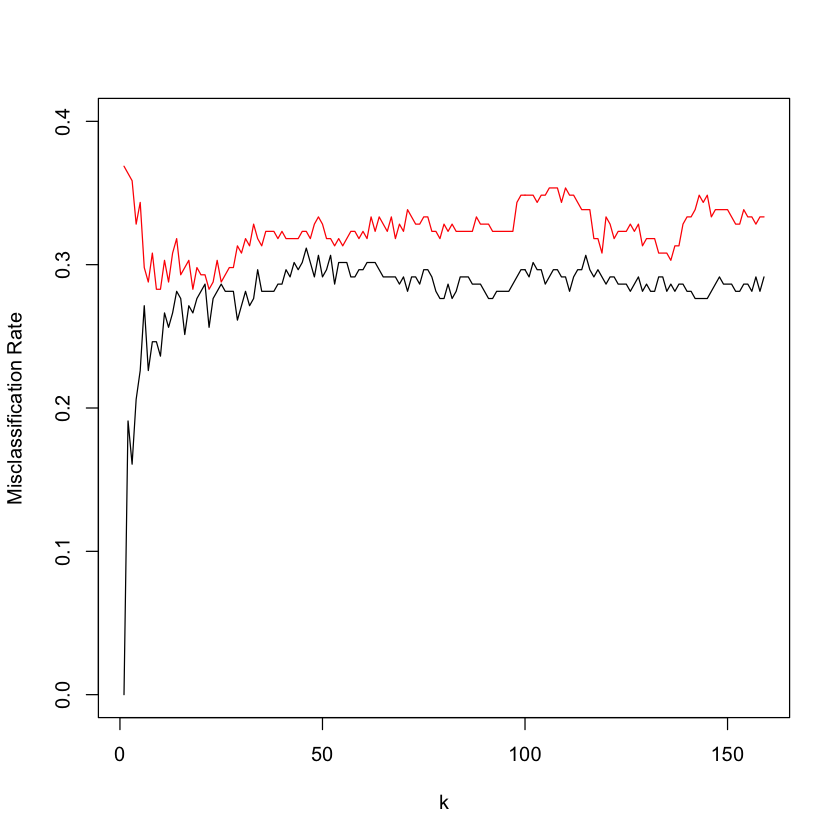

In [56]:
plot(x = Ks, y = knn.models.training.misclassification.rate, type = 'l', col = 1, xlab = 'k', ylab = 'Misclassification Rate', ylim = c(0.0, 0.4))
lines(x = Ks, y = knn.models.test.misclassification.rate, type = 'l', col = 2)

## 2.2 kNN Model selection

*Back to the k-nearest-neighbour, select the optimal value of k via 5-, 10- and LOO-cross validation.*

In [57]:
set.seed(4030)
knn.cv5.model = kNN(training.data, 'cv', 5)
knn.cv5.model$bestTune

,k
109,109


In [58]:
set.seed(4030)
knn.cv10.model = kNN(training.data, 'cv', 10)
knn.cv10.model$bestTune

,k
122,122


In [59]:
set.seed(4030)
knn.loo.model = kNN(training.data, 'loocv')
knn.loo.model$bestTune

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”

,k
143,143


*Are the results similar to the previous ones?*

*Plot k versus the prediction error estimates.*

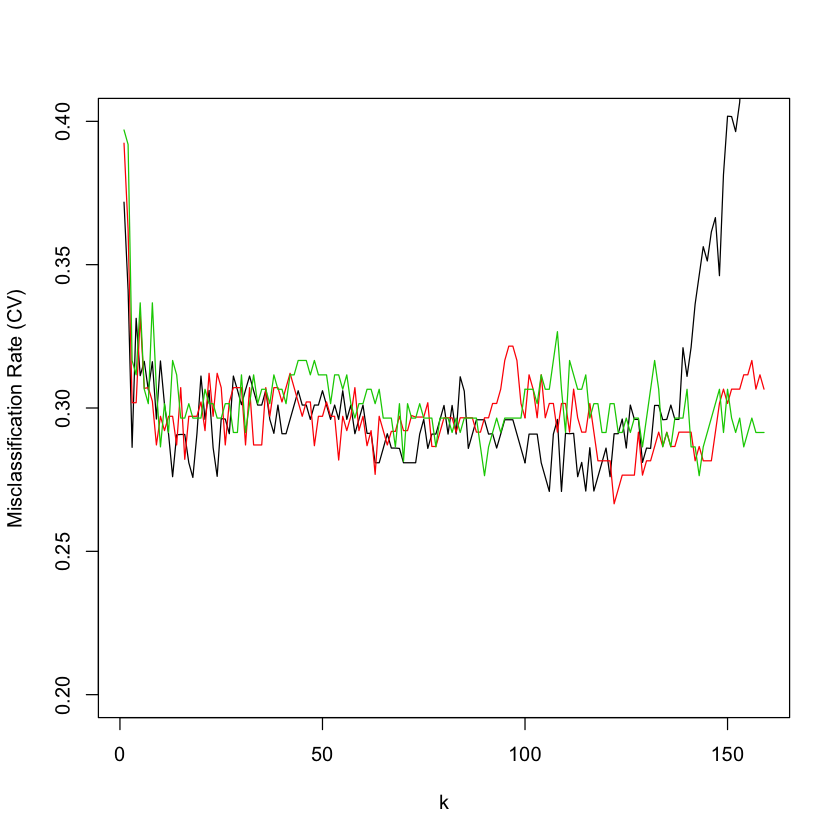

In [60]:
plot(x = Ks, y = knn.cv5.model$misclassification.rate, type = 'l', col = 1, xlab = 'k', ylab = 'Misclassification Rate (CV)', ylim = c(0.2, 0.4))
lines(x = Ks, y = knn.cv10.model$misclassification.rate, type = 'l', col = 2)
lines(x = Ks, y = knn.loo.model$misclassification.rate, type = 'l', col = 3)

*Do the three cross-validation procedures provide similar results?*

*Repeat the selection by using a simple bootstrap procedure and the .632 bootstrap procedure and plot the results as well.*

In [61]:
knn.boot.model = kNN(training.data, 'boot', 100)
knn.boot.model$bestTune

,k
85,85


In [62]:
knn.boot632.model = kNN(training.data, 'boot632', 100)
knn.boot632.model$bestTune

k
1


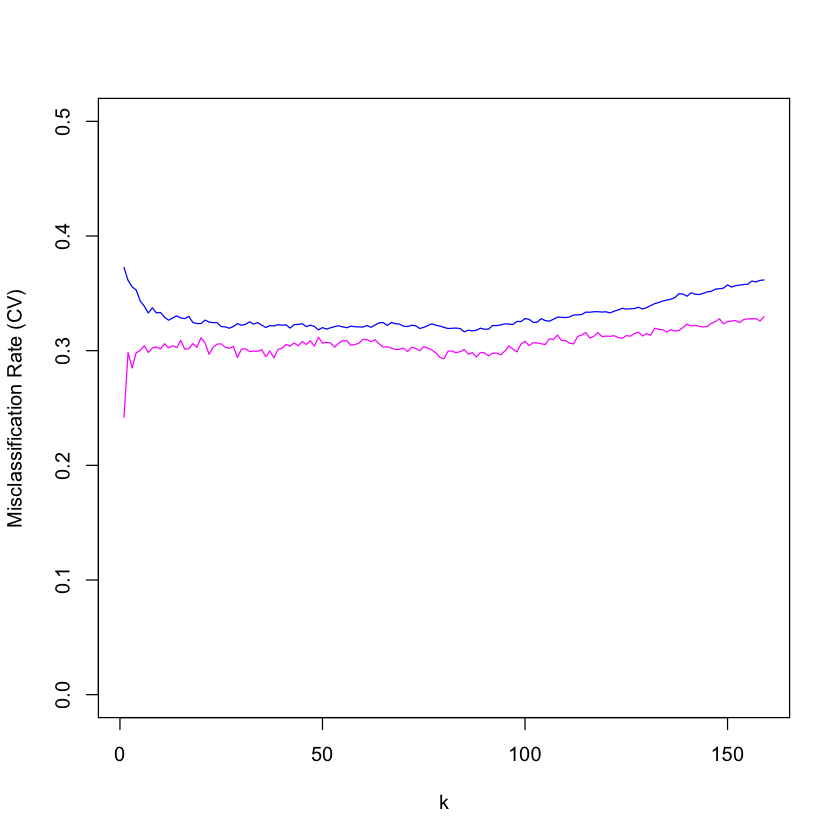

In [63]:
plot(x = Ks, y = knn.boot.model$misclassification.rate, type = 'l', col = 4, xlab = 'k', ylab = 'Misclassification Rate (CV)', ylim = c(0.0, 0.5))
lines(x = Ks, y = knn.boot632.model$misclassification.rate, type = 'l', col = 6)

*Are the results similar to the previous ones?*

## 2.3 Discriminant Analysis

*Use LDA and QDA to classify cases and controls.*

In [15]:
DiscriminantAnalysis = function(data, method) {
    model = train(
        ccstatus ~ .,
        data = data,
        method = method,
        trControl = trainControl(
            method = 'none'
        )
    )
    return(model)
}

In [16]:
lda.model = DiscriminantAnalysis(training.data, 'lda')
MisclassificationRate(list(lda.model), training.data)
MisclassificationRate(list(lda.model), test.data)

[1] 0.2512563

[1] 0.2979798

In [17]:
qda.model = DiscriminantAnalysis(training.data, 'qda')
MisclassificationRate(list(qda.model), training.data)
MisclassificationRate(list(qda.model), test.data)

[1] 0.2763819

[1] 0.3232323

*Which of the two algorithms should be preferred in this case?*

The LDA model performs better on the test set.

## 3.4 Logistic regression

*Repeat the analyses by using logistic regression, penalized versions of it based on L1 and L2 penalties, and L2Boost. Report the regression coefficients and compute training and test errors.*

### Logistic regression

In [122]:
logistic.model = train(
    ccstatus ~ .,
    data = training.data,
    family = "binomial",
    method = "glm"
)

In [135]:
coef(logistic.model$finalModel)
MisclassificationRate(list(logistic.model), training.data)
MisclassificationRate(list(logistic.model), test.data)

(Intercept)      drinks        cigs         age         sex 
-1.04364107  0.03514214  0.03964346 -0.01216435  0.65140495

[1] 0.2562814

[1] 0.3080808

### L1 penalty

In [444]:
PenalizedLogisticRegression = function(formula, data, alpha) {
    set.seed(4030)
    model = train(
        formula,
        data = data,
        preProcess = c('scale'),
        method = "glmnet",
        family = "binomial",
        metric = "Accuracy",
        trControl = trainControl(
            method = 'cv',
            number = 10
        ),
        tuneGrid = expand.grid(
            alpha = alpha,
            lambda = c(0, exp(seq(-2, 2, .1)))
        )
    )
    return(model)
}

In [445]:
logistic.l1.model = PenalizedLogisticRegression(ccstatus ~ ., training.data, alpha = 1)

In [446]:
logistic.l1.model$bestTune['lambda']
as.matrix(coef(logistic.l1.model$finalModel, logistic.l1.model$bestTune$lambda))
MisclassificationRate(list(logistic.l1.model), training.data)
MisclassificationRate(list(logistic.l1.model), test.data)

lambda
0


,1
(Intercept),-1.0475123
drinks,1.3024625
cigs,0.5450105
age,-0.1383019
sex,0.2738075


[1] 0.2562814

[1] 0.3030303

### L2 penalty

In [447]:
logistic.l2.model = PenalizedLogisticRegression(ccstatus ~ ., training.data, alpha = 0)

In [448]:
logistic.l2.model$bestTune['lambda']
as.matrix(coef(logistic.l2.model$finalModel, logistic.l2.model$bestTune$lambda))
MisclassificationRate(list(logistic.l2.model), training.data)
MisclassificationRate(list(logistic.l2.model), test.data)

lambda
0


,1
(Intercept),-0.8616161
drinks,1.0102641
cigs,0.5102538
age,-0.1210673
sex,0.1844486


[1] 0.2663317

[1] 0.3030303

### L2Boost

In [112]:
set.seed(4030)

l2boost.model = train(
    ccstatus ~ .,
    data = training.data,
    method = "glmboost",
    family = Binomial(),
    preProcess = "center",
    tuneGrid = expand.grid(
        mstop = seq(100, 3000, 100),
        prune = "no"
    ),
    trControl = trainControl(
        method = "cv",
        number = 10
    )
)

In [116]:
l2boost.model$bestTune
as.matrix(coef(l2boost.model$finalModel))
MisclassificationRate(list(l2boost.model), training.data)
MisclassificationRate(list(l2boost.model), test.data)

,mstop,prune
2,200,no



NOTE: Coefficients from a Binomial model are half the size of coefficients
 from a model fitted via glm(... , family = 'binomial').
See Warning section in ?coef.mboost



(Intercept),0.078820792
drinks,0.016770168
cigs,0.019059548
age,-0.005341279
sex,0.290503027


[1] 0.2562814

[1] 0.2979798

## AdaBoost

*Implement the algorithm AdaBoost with a tree as a classifier...*

In [4]:
library(rpart)

# AdaBoost M1
# Based on Algorithm 10.1 in ESL
AdaBoost = function(training.data, test.data, iterations) {
    models = list()
    modelWeights = list()

    # Initialize observations weights (w)
    numOfObservations = nrow(training.data)
    observationWeights = rep(1, numOfObservations) / numOfObservations
    
    training.errors = list()
    test.errors = list()
    
    response.variable = 'ccstatus'
    training.truth = training.data[[response.variable]]
    test.truth = test.data[[response.variable]]
    response.levels = levels(training.truth)
    
    AdaBoostPredict = function(predictionData) {
        weightedPredictions = mapply(function (model, index) {
            predictions = predict(model, predictionData, type = "class")
            
            # Prepare for weighting
            levels(predictions) = c(-1, 1)
            predictions = as.numeric(as.character(predictions))
            weightedPredictions = predictions * modelWeights[[index]]
            
            return(weightedPredictions)
        }, models, seq_along(models))
    
        finalPredictions = sign(rowSums(weightedPredictions))
        
        # Convert back to original factors
        finalPredictions = as.factor(finalPredictions)
        levels(finalPredictions) = response.levels

        return(finalPredictions)
    }

    M = 1:iterations
    for (m in M) {
        # Fit a (weak) classifier with weighted observations
        models[[m]] = rpart(
            ccstatus ~ .,
            data = training.data,
            weights = observationWeights,
            method = "class",
            control = rpart.control(
                maxdepth = 1
            )
        )

        # Compute weighted error rate (err_m)
        predictions = predict(models[[m]], training.data, type = "class")
        correctness = (predictions == training.truth)
        weightedErrorRate = sum(observationWeights * !correctness) / sum(observationWeights)
        
        # Compute model weight (alpha_m)
        modelWeights[m] = log((1 - weightedErrorRate) / weightedErrorRate)
        
        # Update observation weights (w)
        observationWeights = observationWeights * exp(modelWeights[[m]] * !correctness)
        
        training.predictions = AdaBoostPredict(training.data)
        test.predictions = AdaBoostPredict(test.data)
        
        training.errors[m] = mean(training.predictions != training.truth)
        test.errors[m] = mean(test.predictions != test.truth)
    }
    
    results = data.frame(
        m = M,
        test.errors = as.numeric(test.errors),
        training.errors = as.numeric(training.errors)
    )
    
    return(results)
}

*...and plot train and test errors as a function of the number of boosting steps (iterations).*

In [5]:
adaBoost.results = AdaBoost(training.data, test.data, 200)

In [6]:
min(adaBoost.results$test.errors)

[1] 0.2727273

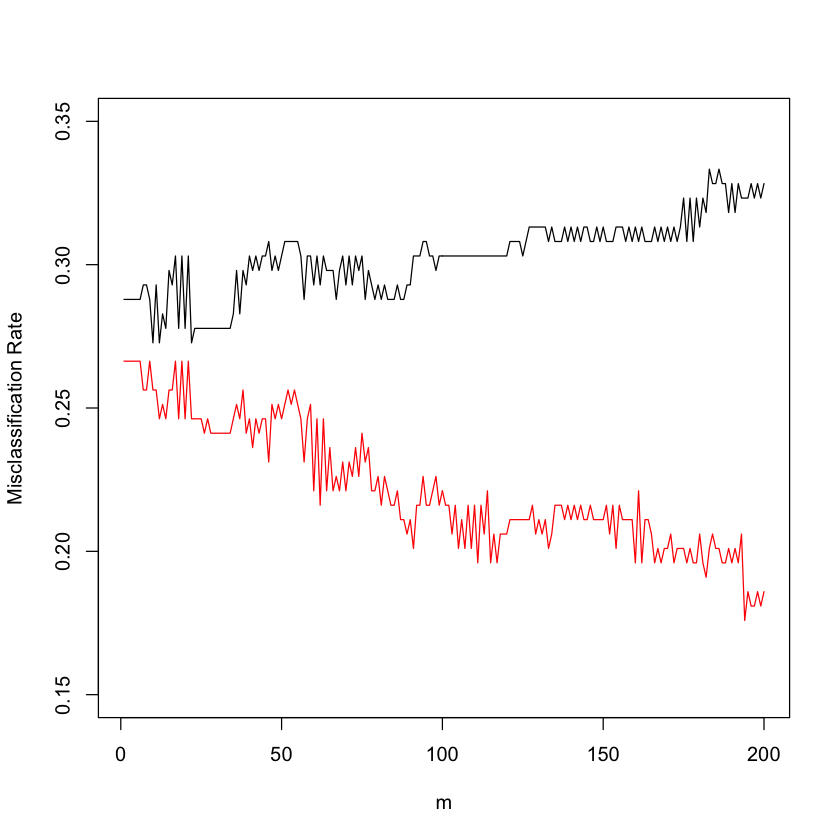

In [7]:
plot(
    x = adaBoost.results$m,
    y = adaBoost.results$test.errors,
    type = 'l',
    xlab = 'm',
    ylab = 'Misclassification Rate',
    ylim = c(0.15, 0.35)
)
lines(
    x = adaBoost.results$m,
    y = adaBoost.results$training.errors,
    col = 2
)

*Would have AdaBoost profited by an early stop in this specific case?*

Yes, the test error has its minimum (0.272727272727273) after 10 iterations.